In [2]:
!pip install transformers torch sklearn matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
import pandas as pd
from google.colab import drive
import zipfile
import os


# === 2. Path to your ZIP file ===
 # Change if needed

# === 3. Unzip it to a folder ===
extract_dir = '/content/drive/MyDrive/Colab Notebooks/NLP'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# === 4. Path to the CSV file inside the ZIP ===
csv_file_path = os.path.join(extract_dir, 'training.1600000.processed.noemoticon.csv')

# === 5. Load and preprocess the dataset ===
df = pd.read_csv(
    csv_file_path,
    encoding='latin-1',
    header=None,
    usecols=[0, 5],
    names=['label', 'tweet_text']
)

# === 6. Handle missing values ===
print("Nulls:\n", df.isnull().sum())
if df['tweet_text'].isnull().sum() > 0:
    df['tweet_text'].fillna(df['tweet_text'].mode()[0], inplace=True)

# === 7. Convert labels: 0 → Negative, 4 → Positive ===
df = df[df['label'].isin([0, 4])]  # Filter out any unexpected labels
df['label'] = df['label'].map({0: 0, 4: 1})

# === 8. Final DataFrame for BERT/Roberta ===
df = df[['tweet_text', 'label']].reset_index(drop=True)

# === 9. Show class distribution ===
print("\nFinal Class Distribution:")
print(df['label'].value_counts())

Nulls:
 label         0
tweet_text    0
dtype: int64

Final Class Distribution:
label
0    800000
1    800000
Name: count, dtype: int64


In [7]:
# === 1. Install Required Libraries ===
# Consolidate installation commands
!pip install -q transformers torch scikit-learn matplotlib
!pip install --upgrade --force-reinstall transformers -q
!pip install -q scikit-learn

# === 2. Import Libraries ===
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Import BertForSequenceClassification from the specific models submodule
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm import tqdm

import zipfile
import os
from google.colab import drive

# === 6. Load Sentiment140 CSV ===
# Correct the csv_path to point to the file inside the extracted directory
csv_file_name = '/content/drive/MyDrive/Colab Notebooks/NLP/training.1600000.processed.noemoticon.csv'
csv_path = os.path.join(csv_file_name)

# Check if the extracted CSV file exists
if not os.path.exists(csv_path):
    print(f"Error: CSV file not found at {csv_path}. Check extraction path and file name.")
    # You might want to exit or handle this error appropriately
else:
    df = pd.read_csv(
        csv_path,
        encoding='latin-1',
        header=None,
        usecols=[0, 5],
        names=['label', 'tweet_text']
    )

    # === 7. Preprocess Data ===
    df = df[df['label'].isin([0, 4])]
    df['label'] = df['label'].map({0: 0, 4: 1})
    df = df[['tweet_text', 'label']].reset_index(drop=True)

    print("Class distribution:")
    print(df['label'].value_counts())

    # === 8. (Optional) Sample smaller subset for faster testing ===
    # df = df.sample(10000, random_state=42).reset_index(drop=True)

    # === 9. Train-test split ===
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['tweet_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )

    # === 10. Tokenizer ===
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # === 11. Dataset Class ===
    class TweetDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts.tolist()
            self.labels = labels.tolist()
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            encoding = self.tokenizer(
                self.texts[idx],
                truncation=True,
                max_length=self.max_len,
                padding='max_length',
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    # === 12. DataLoaders ===
    train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
    test_dataset = TweetDataset(test_texts, test_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    print("Data ready for BERT training ✅")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.
langchain-core 0.3.65 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
Class distribution:
label
0    800000
1    800000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Data ready for BERT training ✅


# **Bert**

Balanced 10k dataset:
label
1    5000
0    5000
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [02:25<00:00,  3.00it/s]


Epoch 1: Train Loss=0.4811, Val Loss=0.4203, Train Acc=0.7739, Val Acc=0.8150


Epoch 2: 100%|██████████| 438/438 [02:29<00:00,  2.92it/s]


Epoch 2: Train Loss=0.3010, Val Loss=0.4295, Train Acc=0.8786, Val Acc=0.8190


Epoch 3: 100%|██████████| 438/438 [02:29<00:00,  2.92it/s]


Epoch 3: Train Loss=0.1412, Val Loss=0.5873, Train Acc=0.9463, Val Acc=0.8000


Epoch 4: 100%|██████████| 438/438 [02:30<00:00,  2.90it/s]


Epoch 4: Train Loss=0.0602, Val Loss=0.8463, Train Acc=0.9803, Val Acc=0.7960


Epoch 5: 100%|██████████| 438/438 [02:31<00:00,  2.90it/s]


Epoch 5: Train Loss=0.0381, Val Loss=1.0499, Train Acc=0.9874, Val Acc=0.8000


Epoch 6: 100%|██████████| 438/438 [02:30<00:00,  2.90it/s]


Epoch 6: Train Loss=0.0235, Val Loss=0.8888, Train Acc=0.9923, Val Acc=0.7980
Early stopping

Final Test Metrics:
Accuracy: 0.8000
Precision: 0.8080
Recall: 0.7870
F1-Score: 0.7974
MCC: 0.6002
MAE: 0.2000
MSE: 0.2000
RMSE: 0.4472
Cohen's Kappa: 0.6000
AUC-ROC: 0.8801
CSI: 0.6630


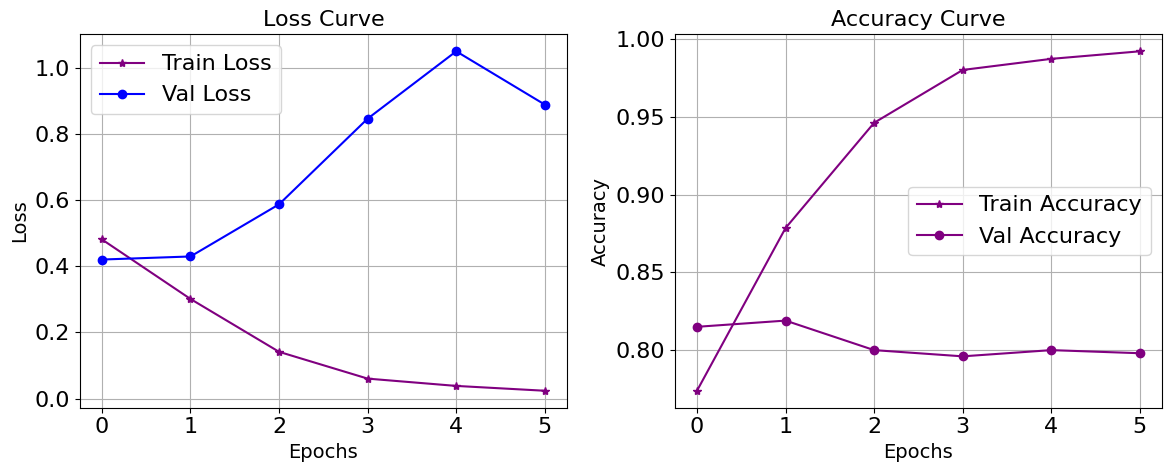

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/Colab Notebooks/NLP'

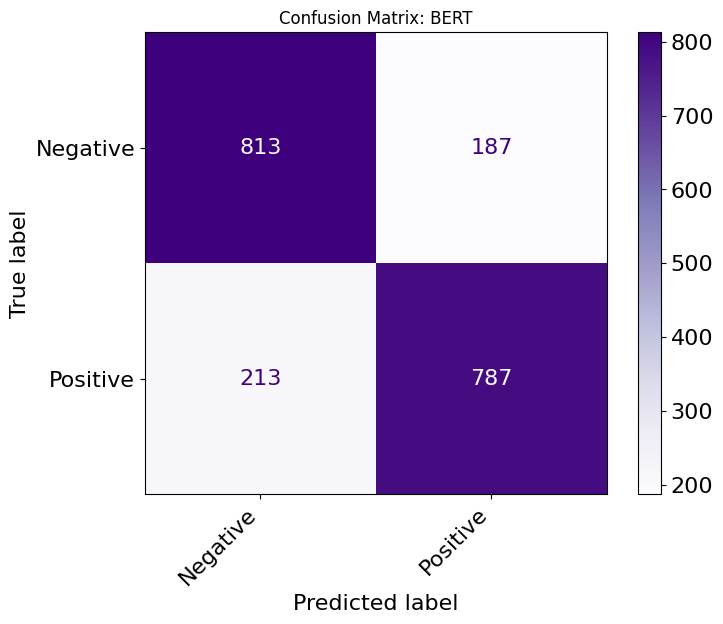

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# === 1. Balance dataset to exactly 5000 samples per class (total 10,000) ===
balanced_df = pd.concat([
    df[df['label'] == 0].sample(5000, random_state=42),
    df[df['label'] == 1].sample(5000, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced 10k dataset:")
print(balanced_df['label'].value_counts())


# === 2. Split into 70% train, 20% test, 10% val ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_df['tweet_text'], balanced_df['label'],
    test_size=0.3, stratify=balanced_df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)

# === 3. Tokenization ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# === 4. Model Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 5. Training ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
best_val_loss = float('inf')
patience = 5
num_epochs = 30
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)

    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping")
            break

# === 6. Load Best Model and Evaluate ===
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === 7. Metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0

print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")

# === 8. Plot Loss and Accuracy Curves ===
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')

plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()

# Accuracy curve

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='purple', marker='o')

plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('Bert1_training_curves.png', dpi=300)
plt.show()


# === 9. Styled Confusion Matrix (Purple + Saved as PDF) ===
labels = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')

plt.title('Confusion Matrix: BERT', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})

plt.savefig('/content/drive/MyDrive/Colab Notebooks/NLP', format='png', dpi=300, bbox_inches='tight')
plt.show()



# **Roberta**

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [02:27<00:00,  2.97it/s]


Epoch 1: Train Loss=0.4655, Val Loss=0.4054, Train Acc=0.7799, Val Acc=0.8360


Epoch 2: 100%|██████████| 438/438 [02:32<00:00,  2.88it/s]


Epoch 2: Train Loss=0.3198, Val Loss=0.3870, Train Acc=0.8664, Val Acc=0.8390


Epoch 3: 100%|██████████| 438/438 [02:32<00:00,  2.87it/s]


Epoch 3: Train Loss=0.2249, Val Loss=0.4853, Train Acc=0.9110, Val Acc=0.8430


Epoch 4: 100%|██████████| 438/438 [02:32<00:00,  2.88it/s]


Epoch 4: Train Loss=0.1525, Val Loss=0.4952, Train Acc=0.9407, Val Acc=0.8400


Epoch 5: 100%|██████████| 438/438 [02:32<00:00,  2.88it/s]


Epoch 5: Train Loss=0.1133, Val Loss=0.5828, Train Acc=0.9596, Val Acc=0.8360


Epoch 6: 100%|██████████| 438/438 [02:32<00:00,  2.88it/s]


Epoch 6: Train Loss=0.0791, Val Loss=0.5322, Train Acc=0.9704, Val Acc=0.8430


Epoch 7: 100%|██████████| 438/438 [02:32<00:00,  2.88it/s]


Epoch 7: Train Loss=0.0635, Val Loss=0.6461, Train Acc=0.9780, Val Acc=0.8400
Early stopping

Final Test Metrics:
Accuracy: 0.8370
Precision: 0.8467
Recall: 0.8230
F1-Score: 0.8347
MCC: 0.6743
MAE: 0.1630
MSE: 0.1630
RMSE: 0.4037
Cohen's Kappa: 0.6740
AUC-ROC: 0.9166
CSI: 0.7163


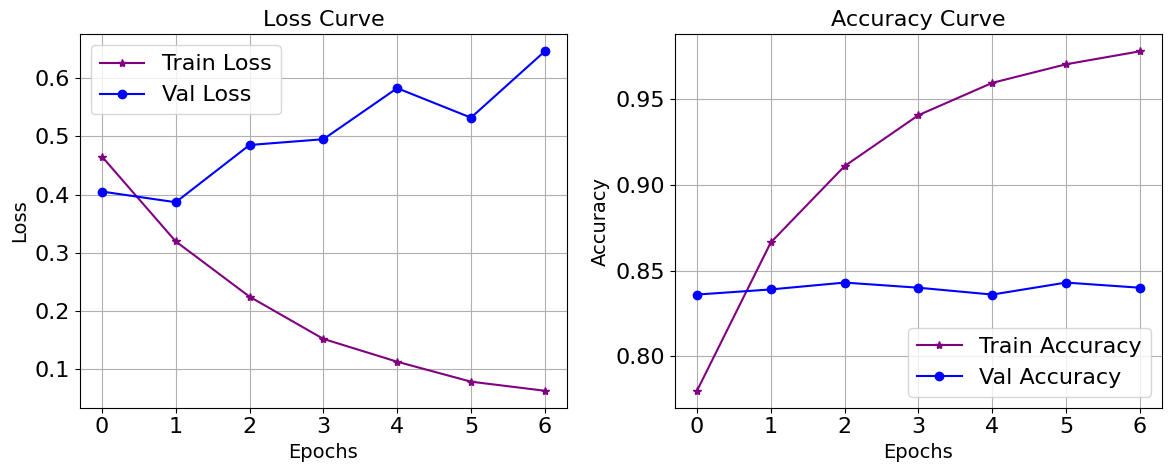

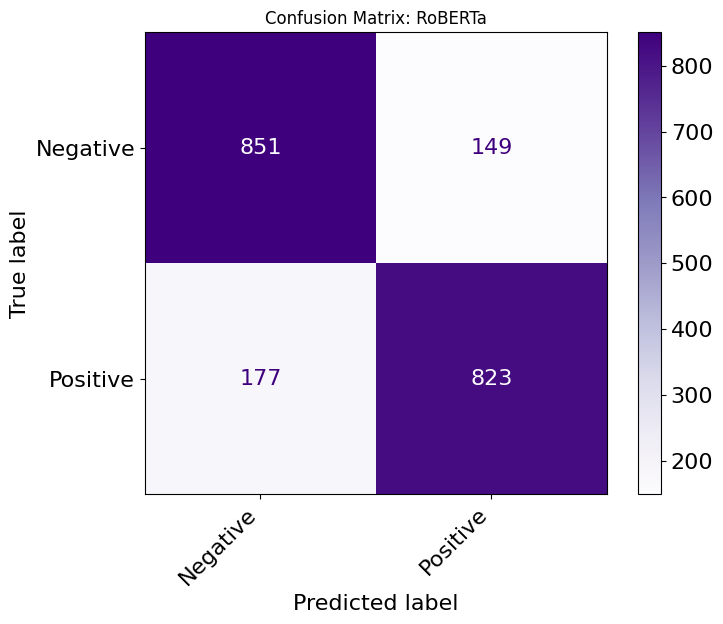

In [12]:
import os

save_dir = '/content/drive/MyDrive/Colab Notebooks/NLP'

os.makedirs(save_dir, exist_ok=True)

# === Imports ===

import torch

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaForSequenceClassification

from torch.optim import AdamW

from sklearn.model_selection import train_test_split

from sklearn.metrics import (

    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,

    precision_recall_fscore_support, matthews_corrcoef,

    mean_absolute_error, mean_squared_error,

    cohen_kappa_score, roc_auc_score

)

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from tqdm import tqdm

# === 1. Balance dataset to exactly 5000 per class ===

sample_size = 5000

balanced_df = pd.concat([

    df[df['label'] == cls].sample(sample_size, random_state=42)

    for cls in df['label'].unique()

]).sample(frac=1, random_state=42).reset_index(drop=True)

# === 2. Split into train/val/test (70/10/20) ===

train_texts, temp_texts, train_labels, temp_labels = train_test_split(

    balanced_df['tweet_text'], balanced_df['label'],

    test_size=0.3, stratify=balanced_df['label'], random_state=42

)

val_texts, test_texts, val_labels, test_labels = train_test_split(

    temp_texts, temp_labels,

    test_size=2/3, stratify=temp_labels, random_state=42

)

# === 3. Tokenization ===

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class TweetDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len=128):

        self.texts = texts.tolist()

        self.labels = labels.tolist()

        self.tokenizer = tokenizer

        self.max_len = max_len

    def __len__(self):

        return len(self.labels)

    def __getitem__(self, idx):

        encoding = self.tokenizer(

            self.texts[idx],

            truncation=True,

            max_length=self.max_len,

            padding='max_length',

            return_tensors='pt'

        )

        return {

            'input_ids': encoding['input_ids'].squeeze(0),

            'attention_mask': encoding['attention_mask'].squeeze(0),

            'labels': torch.tensor(self.labels[idx], dtype=torch.long)

        }

train_dataset = TweetDataset(train_texts, train_labels, tokenizer)

val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

test_dataset = TweetDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16)

test_loader = DataLoader(test_dataset, batch_size=16)

# === 4. Model Setup ===

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# === 5. Training ===

train_loss_list, val_loss_list = [], []

train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')

patience = 5

num_epochs = 30

trigger_times = 0

for epoch in range(num_epochs):

    model.train()

    total_train_loss = 0

    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss

        logits = outputs.logits

        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        correct_train += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)

    train_acc = correct_train / len(train_dataset)

    model.eval()

    val_loss = 0

    correct_val = 0

    with torch.no_grad():

        for batch in val_loader:

            input_ids = batch['input_ids'].to(device)

            attention_mask = batch['attention_mask'].to(device)

            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)

            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)

    val_acc = correct_val / len(val_dataset)

    train_loss_list.append(avg_train_loss)

    val_loss_list.append(avg_val_loss)

    train_acc_list.append(train_acc)

    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if avg_val_loss < best_val_loss:

        best_val_loss = avg_val_loss

        trigger_times = 0

        torch.save(model.state_dict(), os.path.join(save_dir, 'best_roberta.pth'))

    else:

        trigger_times += 1

        if trigger_times >= patience:

            print("Early stopping")

            break

# === 6. Load Best Model and Evaluate ===

model.load_state_dict(torch.load(os.path.join(save_dir, 'best_roberta.pth')))

model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():

    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        probs = torch.softmax(outputs.logits, dim=1)[:, 1]

        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())

# === 7. Metrics ===

test_acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

mcc = matthews_corrcoef(all_labels, all_preds)

mae = mean_absolute_error(all_labels, all_preds)

mse = mean_squared_error(all_labels, all_preds)

rmse = np.sqrt(mse)

kappa = cohen_kappa_score(all_labels, all_preds)

auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)

TP = cm[1,1]

FN = cm[1,0]

FP = cm[0,1]

CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0

print("\nFinal Test Metrics:")

print(f"Accuracy: {test_acc:.4f}")

print(f"Precision: {precision:.4f}")

print(f"Recall: {recall:.4f}")

print(f"F1-Score: {f1:.4f}")

print(f"MCC: {mcc:.4f}")

print(f"MAE: {mae:.4f}")

print(f"MSE: {mse:.4f}")

print(f"RMSE: {rmse:.4f}")

print(f"Cohen's Kappa: {kappa:.4f}")

print(f"AUC-ROC: {auc_roc:.4f}")

print(f"CSI: {CSI:.4f}")

# === 8. Plot Loss and Accuracy Curves ===

plt.figure(figsize=(12, 5))

# Loss

plt.subplot(1, 2, 1)

plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')

plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')

plt.title("Loss Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Loss", fontsize=14)

plt.grid(True)

plt.legend()

# Accuracy

plt.subplot(1, 2, 2)

plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')

plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')

plt.title("Accuracy Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)

plt.grid(True)

plt.legend()

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'roberta_training_curves.png'), dpi=300)

plt.show()

# === 9. Confusion Matrix ===

labels = ['Negative', 'Positive']

conf_matrix = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))

disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')

plt.title('Confusion Matrix: RoBERTa', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.rcParams.update({'font.size': 16})

plt.savefig(os.path.join(save_dir, 'roberta_confusion_matrix.png'), format='png', dpi=300, bbox_inches='tight')

plt.show()

